# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import numpy as np
D = np.loadtxt('/content/lin_reg.txt', delimiter=',')
X = D[:, :-1]
y = D[:, -1]


In [2]:
import sklearn.datasets as ds
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional
from torch.utils.data import TensorDataset, DataLoader, random_split,Dataset
%matplotlib inline

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 
X = torch.LongTensor(X)
X.to(device)
y = y.reshape(-1,1)
y = torch.LongTensor(y)
l = len(X)
print(X)
y.to(device)
data = TensorDataset(X, y)
print(data)
train_data, test_data, val_data = random_split(data, [int(l * 0.7), int(l * 0.2), l - int(l * 0.7) - int(l * 0.2)])
print(X.shape)
y.shape


tensor([[  9, -17,  20,  11],
        [ -6, -12, -12, -14],
        [ 14,  -9,  29,   1],
        ...,
        [  3,   2,   7,  -7],
        [ 11, -14,  23,  11],
        [ -3, -15,  -4,  -1]])
torch.Size([1000, 4])


torch.Size([1000, 1])

In [3]:
model = nn.Linear(4, 1).to(device)


In [4]:
def mse(y, y_pred, lambd):
  weight_p=[]
  bias_p =[]
  for name, p in model.named_parameters():
    if 'bias' in name:
      bias_p += [p]
    else:
      weight_p += [p]
  weight_p = torch.stack(weight_p).to(device)
  return (y - y_pred).pow(2).mean()+ lambd * torch.norm(weight_p).pow(2)

Epoch = 0,loss = 10045.90234375
Epoch = 10,loss = 5222.1865234375
Epoch = 20,loss = 3346.214111328125
Epoch = 30,loss = 2302.669189453125
Epoch = 40,loss = 1623.734375
Epoch = 50,loss = 1160.0675048828125
Epoch = 60,loss = 839.0848388671875
Epoch = 70,loss = 616.0552978515625
Epoch = 80,loss = 460.9434814453125
Epoch = 90,loss = 353.06268310546875


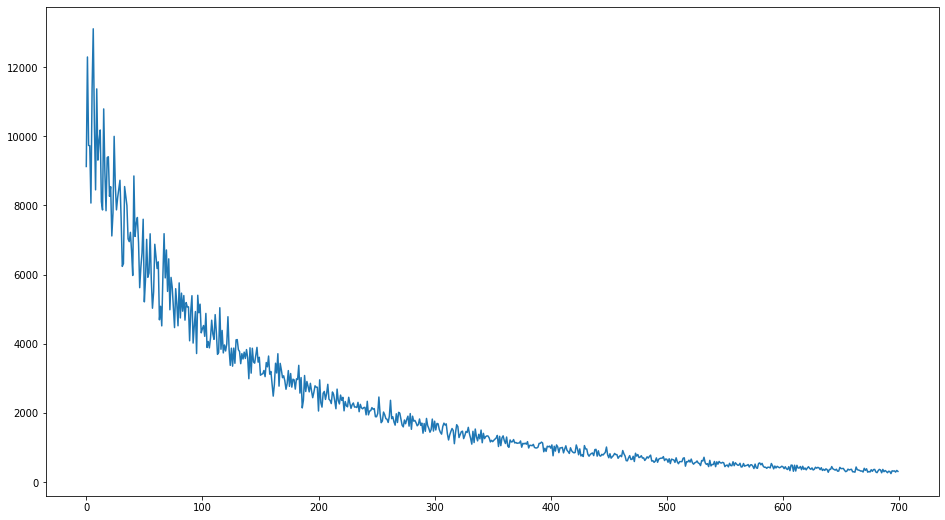

In [5]:
def train_model(model, train_data, val_data, max_epochs=100, lambd = 0.1):
    losses =[]
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
    train_loader = DataLoader(dataset=train_data, batch_size=100, shuffle=True)
    for epoch in range(max_epochs):
        for X_batch, y_batch in train_loader:
            model = model.train()
            y_pred = model(X_batch.float())
            loss1 = mse(y_pred.float(), y_batch.float(),lambd)
            losses.append(float(mse(y_pred,y_batch.float(),lambd)))
            loss1.backward()
            optimizer.step()
            optimizer.zero_grad()
        if epoch % 10 == 0:
            print(f'Epoch = {epoch},loss = {mse(model(X.float()),y.float(),lambd)}')
    return losses
losses= train_model(model, train_data, val_data)
plt.figure(figsize=(16, 9))
plt.plot(losses)

In [6]:
def Validate(model, val_data, lambd):
    val_loader = DataLoader(dataset=val_data, batch_size=100, shuffle=True)
    model = model.eval()
    losses = []
    for X_batch, y_batch in val_loader:
        y_pred = model(X_batch.float())
        loss1 = mse(y_pred,y_batch,lambd)
        losses.append(float(loss1))
    return losses

In [7]:
def cross_validate(model,dataset=data,lambd=0.1):
  import torch
  import pandas as pd
  train_score = []
  val_score =  []
  total = X.shape[0]
  cross = int(total/5)
  for i in range(5):
    model = nn.Linear(4, 1).to(device)
    train_data = torch.utils.data.Subset(dataset,list(range(0,i*cross))+list(range(i*cross+cross,total)))
    val_data = torch.utils.data.Subset(dataset,list(range(i*cross,i*cross+cross)))
    train_loss = train_model(model,train_data,val_data,max_epochs = 25, lambd = lambd)
    train_score.append(train_loss)
    val_loss = Validate(model,val_data,lambd)
    val_score.append(val_loss)
  return train_score,val_score


Epoch = 0,loss = 11835.9775390625
Epoch = 10,loss = 5112.19775390625
Epoch = 20,loss = 3063.551025390625
Epoch = 0,loss = 9030.591796875
Epoch = 10,loss = 4184.90771484375
Epoch = 20,loss = 2576.05029296875
Epoch = 0,loss = 9554.2080078125
Epoch = 10,loss = 4459.4833984375
Epoch = 20,loss = 2760.03125
Epoch = 0,loss = 10373.9853515625
Epoch = 10,loss = 5117.517578125
Epoch = 20,loss = 3211.24609375
Epoch = 0,loss = 9826.509765625
Epoch = 10,loss = 4892.7109375
Epoch = 20,loss = 3060.357666015625
Epoch = 0,loss = 10847.3935546875
Epoch = 10,loss = 4925.169921875
Epoch = 20,loss = 3007.22314453125
Epoch = 0,loss = 10617.5703125
Epoch = 10,loss = 4671.91064453125
Epoch = 20,loss = 2829.0869140625
Epoch = 0,loss = 10015.275390625
Epoch = 10,loss = 4327.54541015625
Epoch = 20,loss = 2618.728271484375
Epoch = 0,loss = 10747.6689453125
Epoch = 10,loss = 4936.986328125
Epoch = 20,loss = 3034.646240234375
Epoch = 0,loss = 12114.2861328125
Epoch = 10,loss = 5562.88720703125
Epoch = 20,loss = 338

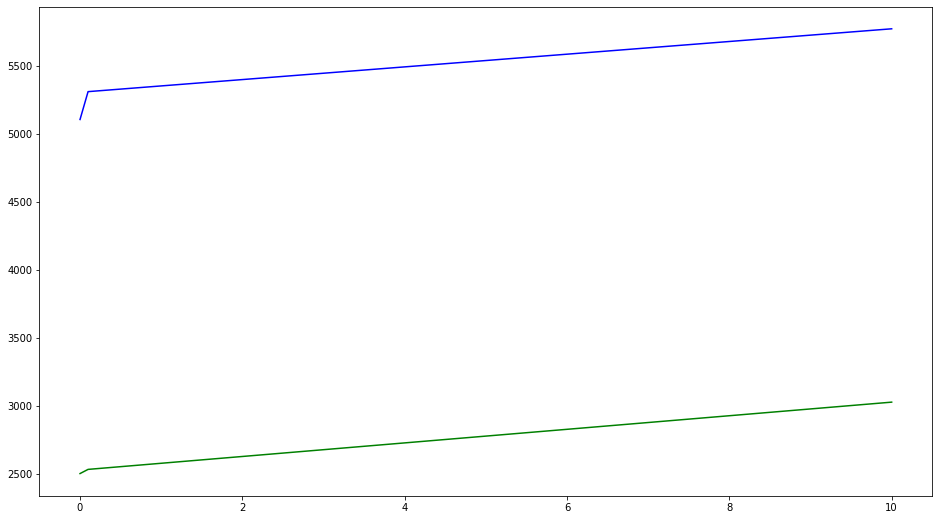

In [8]:
coefs = [0.001,0.1,10]
val_losses = []
train_losses = []
for coef in coefs:
  train_l,val_l = cross_validate(model,data,lambd=coef)
  val_losses.append(np.array(val_l).mean())
  train_losses.append(np.array(train_l).mean())
plt.figure(figsize=(16, 9))
plt.plot(coefs,train_losses,color='b')
plt.plot(coefs,val_losses,color='g')
plt.show()


При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.